# Kinematic smearing

In [1]:
import sys

sys.path.append("/nfs/dust/belle2/user/kapitanl/Analysis/PRG_MPI/thumair_jpsiks/pythonTools")
sys.path.append("/nfs/dust/belle2/user/kapitanl/Analysis/PRD_MPI/Lib_Xgboost/xgboost/python-package")
!{sys.executable} -m pip install iminuit==2.2.1

%env TOERASEDIR=/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/filesForRemove

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/bin/python3.6m -m pip install --upgrade pip' command.
env: TOERASEDIR=/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/filesForRemove


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pdf
import pandas as pd
import rootTools as tap
plt.rcParams["figure.figsize"] = (14,10)

Welcome to JupyROOT 6.20/04


In [3]:
import noteBookTools as nbt
totDicts = nbt.getDictForBDT()
listVars = [totDict['var'] for totDict in totDicts] + ['KFold', 'TagVLBoost', 'TagVmcLBoost', 'TagVLBoostErr', 'MCDeltaT','DeltaT']
listFormulas = [totDict['form'] for totDict in totDicts] + ['__event__ % 2', 'TagVLBoost', 'TagVmcLBoost', 'TagVLBoostErr', 'MCDeltaT', 'DeltaT']

totDictKins = nbt.getDictForBToDPi("BPtoPiD0toKPi")
listVarKins = [totDictKin['var'] for totDictKin in totDictKins] 
listFormulaKins = [totDictKin['form'] for totDictKin in totDictKins] 

In [4]:
tupleDir = "/nfs/dust/belle2/user/jkandra/MC13-04/BPtoPiD0toKPi/"

In [5]:
Data = tap.getPandaFromFiles(fileNames=[tupleDir+"BPtoPiD0toKPi.root"],
                               listVarFormulas=listFormulas + listFormulaKins,
                                listVarNames=listVars + listVarKins, 
                                treeName="BpToD0pip_DtoKpi", cut="isSignal")

........... 


In [6]:
vData = Data["DeltaT"].to_numpy()

## Resolution function

bgc 86.12366327934411
{'mus': -0.03968490158774369, 'sigmas': 0.3718182672820324, 'fTMains': 0.41653307344882307, 'fTR': 0.325183040392006, 'fTBigs': 0.11728238115547562, 'cLMs': 0.702119332580259, 'cRMs': 0.5413104204621249, 'cLBs': 0.11356009480351467, 'cRBs': 0.06779296446120844, 'bigSigmaScale': 2.2177552315040954, 'bigSigmaFrac': 0.3658011171290139}
# events 1240099


/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/chebFitter/python/pdf.py:47: RuntimeWarning: invalid value encountered in double_scalars
  r = abs(c.real) * np.exp(c*(m1+m2) + (sigma**2 * c**2)/2 - c*x - arg**2) * 0.5 * erfcx(arg)


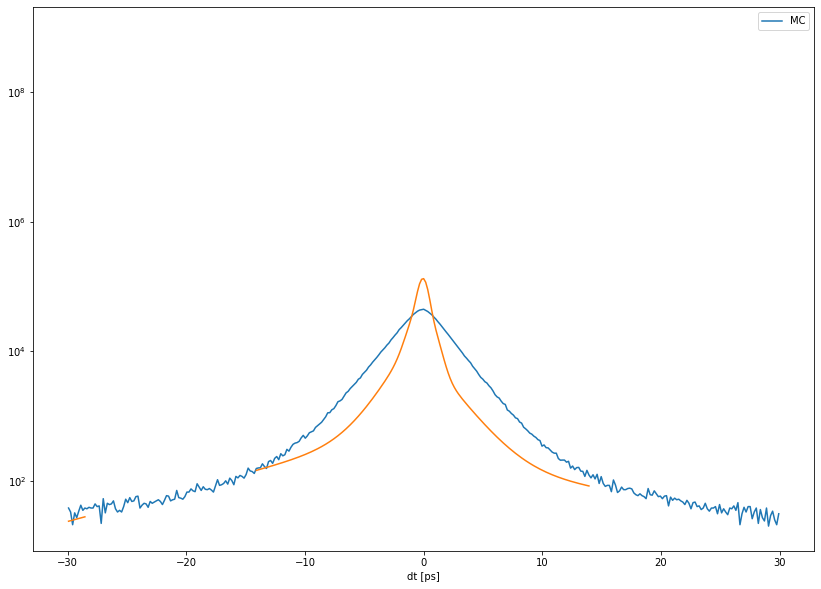

In [7]:
# Transform parameters from um to ps

beta = 276.11e-3
c = 299.792458 # um/ps
bgc = beta/(1 - beta**2)**0.5 * c
print('bgc', bgc)


'''pars = {
   'mus': -0.07029368571683735 / bgc,
   'sigmas': 0.3918262885418164/ bgc,
   'fTMains': 0.1402839955940452, 
   'fTR': 0.3601912814334793,
   'cLMs': 0.1036841394460027 * bgc,
   'cRMs': 0.06803381698743874 * bgc,
   'bigSigmaScale': 2.1767453589245225,
   'bigSigmaFrac': 0.6036344190332074,
   'fTBigs': 0.6268934047143494,
   'cLBs': 0.5720441320352365 * bgc,
   'cRBs': 0.48831611234179223 * bgc
}
'''
#parameters from mcDeltaT - DeltaT fit : already the right units
pars = {'mus': -0.03968490158774369, 'sigmas': 0.3718182672820324,
        'fTMains': 0.41653307344882307, 'fTR': 0.325183040392006, 
        'fTBigs': 0.11728238115547562, 'cLMs': 0.702119332580259, 
        'cRMs': 0.5413104204621249, 'cLBs': 0.11356009480351467, 
        'cRBs': 0.06779296446120844, 'bigSigmaScale': 2.2177552315040954,
        'bigSigmaFrac': 0.3658011171290139}

print(pars)

# Dummy parameters for no resolution smearing
pars0 = pars.copy()
pars0["mus"] = 0
pars0["sigmas"] = 0.0001
pars0["fTMains"] = 0
pars0["bigSigmaFrac"] = 0


xLim = 30
x = np.linspace(-xLim, xLim, 350)

#MC histogram
hMC = np.histogram((vData), bins=x)
xH = (hMC[1][1:] + hMC[1][:-1]) / 2
xSize = (xH[1:] - xH[:-1]) / 2


print('# events', np.sum(hMC[0]))
y1 = np.vectorize(lambda t : pdf.resFun(t, pars))(xH)
#y = np.vectorize(lambda t : pdf.resFun(t, pars))(x)
y0 = np.vectorize(lambda t : pdf.resFun(t, pars0))(xH)


#scaling factor for multiplying the normalized function 
C1 = np.sum(hMC[0])/np.sum(yOrt)
C2 = np.sum(hMC[0])/np.sum(y1)



plt.plot(xH, hMC[0], label="MC")
#plt.plot(xH,C*y )
plt.plot(xH, C2*y1)
plt.plot(xH, C1*y0)

plt.legend()
plt.yscale("log")
plt.xlabel("dt [ps]")


dirName = "/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/"
plt.savefig(dirName+"BPtoPiD0toKPi_pdfTest.png", bbox_inches='tight')

## B Decays

Plot of the B-decay time for various thetaCMS, looks like huge differences

/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/chebFitter/python/pdf.py:47: RuntimeWarning: invalid value encountered in double_scalars
  r = abs(c.real) * np.exp(c*(m1+m2) + (sigma**2 * c**2)/2 - c*x - arg**2) * 0.5 * erfcx(arg)
/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/chebFitter/python/pdf.py:53: RuntimeWarning: invalid value encountered in double_scalars
  r = e2[1].real/(e2[1] - e1[1])*GE_conv(g, [e1[0]+e2[0], e1[1]], x) - e1[1].real/(e2[1] - e1[1])*GE_conv(g, [e1[0]+e2[0], e2[1]], x)


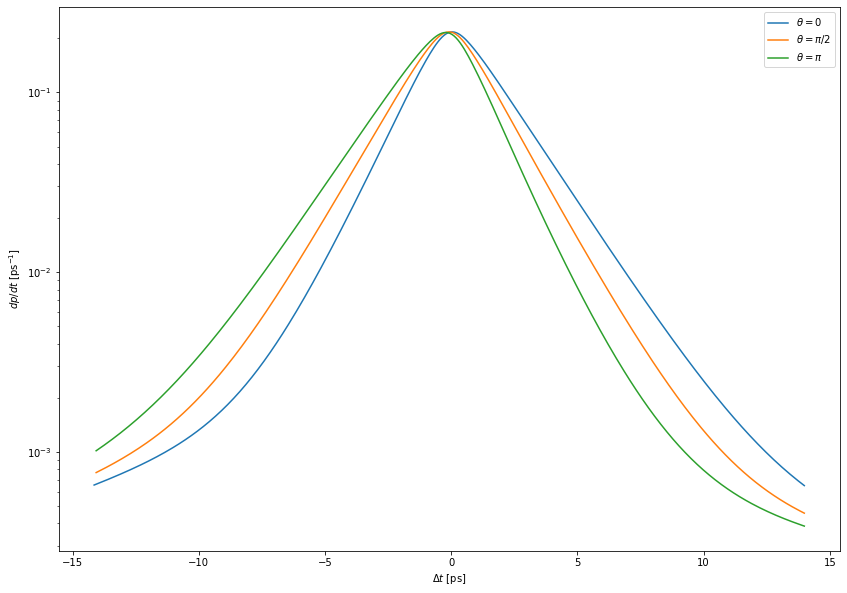

In [8]:
xLim = 5
x    = np.linspace(-4*xLim, 4*xLim, 500 )
tau = 1.520
y0   = np.vectorize(lambda t : pdf.funDecayTheta(t, pars, tau=tau, theta=0))(x)
yOrt = np.vectorize(lambda t : pdf.funDecayTheta(t, pars, tau=tau, theta=np.pi/2))(x)
y1   = np.vectorize(lambda t : pdf.funDecayTheta(t, pars, tau=tau, theta=np.pi))(x)
#yOrtR= np.vectorize(lambda t : pdf.funDecayTheta(t, pars0, np.pi/2))(x)

plt.plot(x, y0,   label=r'$\theta=0$')
plt.plot(x, yOrt, label=r'$\theta=\pi/2$')
plt.plot(x, y1,   label=r'$\theta=\pi$')
plt.ylabel('$dp/dt$ [ps$^{-1}$]')
plt.xlabel(r'$\Delta t$ [ps]')
plt.legend()
plt.yscale("log")

Plot the comparizon of the theta-integrated scenario and the case with no kin-smearing effect

/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/chebFitter/python/pdf.py:47: RuntimeWarning: invalid value encountered in double_scalars
  r = abs(c.real) * np.exp(c*(m1+m2) + (sigma**2 * c**2)/2 - c*x - arg**2) * 0.5 * erfcx(arg)
/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/chebFitter/python/pdf.py:53: RuntimeWarning: invalid value encountered in double_scalars
  r = e2[1].real/(e2[1] - e1[1])*GE_conv(g, [e1[0]+e2[0], e1[1]], x) - e1[1].real/(e2[1] - e1[1])*GE_conv(g, [e1[0]+e2[0], e2[1]], x)


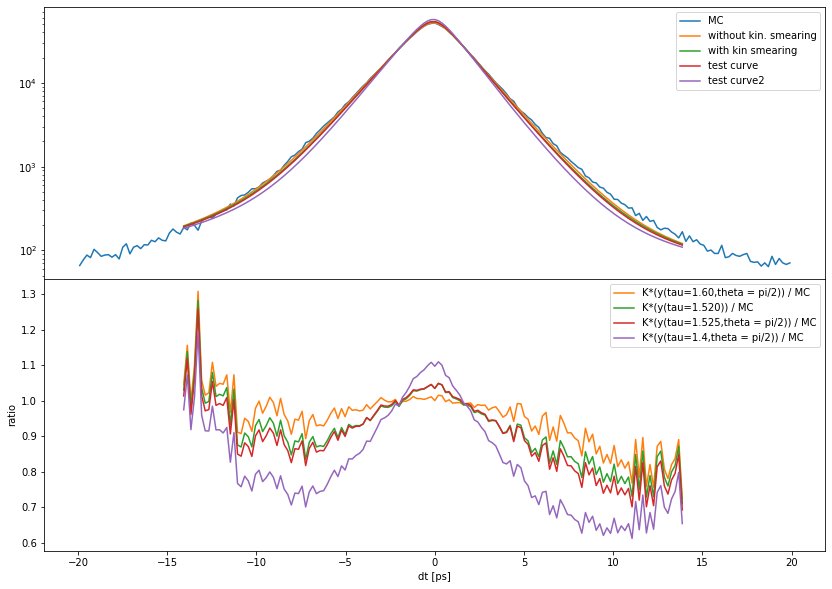

In [10]:
x    = np.linspace(-4*xLim, 4*xLim, 200 )

hMC = np.histogram((vData), bins=x)
xH = (hMC[1][1:] + hMC[1][:-1]) / 2
xSize = (x[1:] - x[:-1]) / 2

yOrt  = np.vectorize(lambda t : pdf.funDecayTheta(t, pars, tau=1.6, theta=np.pi/2))(xH)
yTest = np.vectorize(lambda t : pdf.funDecayTheta(t, pars, tau=1.003*tau, theta=np.pi/2))(xH)
ySm   = np.vectorize(lambda t : pdf.funDecay(t, pars, tau=tau))(xH)
yTest2 =np.vectorize(lambda t : pdf.funDecayTheta(t, pars, tau = 1.4,theta=np.pi/2))(xH)





plt.plot()
plt.subplots_adjust(hspace=0)
ax = plt.subplot(211)

C1 = np.sum(hMC[0])/np.sum(yOrt)
C2 = np.sum(hMC[0])/np.sum(ySm)
C3 = np.sum(hMC[0])/np.sum(yTest)
C4 = np.sum(hMC[0])/np.sum(yTest2)

plt.plot(xH, hMC[0], label="MC")
plt.plot(xH, C1*yOrt, label='without kin. smearing')
plt.plot(xH, C2*ySm, label='with kin smearing')
plt.plot(xH, C3*yTest, label='test curve')
plt.plot(xH, C4*yTest2, label='test curve2')
#plt.plot(x, 1500*yTest, label='test curve') x = 1
  
        
                
plt.yscale("log")
#plt.xlabel("dt [ps]")
plt.legend()
plt.subplot(212, sharex=ax)


#plt.plot(x, ySm / yOrt, color='C1')
#plt.plot(x, yTest / yOrt, color='C2')


plt.plot(xH, C1*yOrt/hMC[0], color = 'C1', label = 'K*(y(tau=1.60,theta = pi/2)) / MC')
plt.plot(xH, C2*ySm / hMC[0], color = 'C2', label = 'K*(y(tau=1.520)) / MC')
plt.plot(xH, C3*yTest / hMC[0], color = 'C3', label = 'K*(y(tau=1.525,theta = pi/2)) / MC')
plt.plot(xH, C4*yTest2 / hMC[0], color = 'C4', label = 'K*(y(tau=1.4,theta = pi/2)) / MC')

plt.xlabel("dt [ps]")
plt.legend()
plt.ylabel("ratio")

dirName = "/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/"
plt.savefig(dirName+"BPtoPiD0toKPi_BDecays.png", bbox_inches='tight')

# Fit

In [11]:
# Resolution function convoluted with (complex) exp
def FunT(x, pars2, c):
    
    mus = -0.03968490158774369
    sigmas = 0.3718182672820324
    fTMains = 0.41653307344882307
    fTR = 0.325183040392006
    fTBigs = 0.11728238115547562
    cLMs = 0.702119332580259
    cRMs = 0.5413104204621249
    cLBs = 0.11356009480351467
    cRBs = 0.06779296446120844
    bigSigmaScale = 2.2177552315040954
    bigSigmaFrac = 0.3658011171290139
    
    ret = 0
    
    # small gauss
    ret += (1-bigSigmaFrac) * (1-fTMains) * pdf.GE_conv([mus, sigmas], [0,c], x)
    ret += (1-bigSigmaFrac) * fTMains*(1.-fTR)* pdf.GEE_conv([mus,sigmas], [mus, -cLMs], [0, c], x) 
    ret += (1-bigSigmaFrac) * fTMains*(fTR)* pdf.GEE_conv([mus,sigmas], [mus, +cRMs], [0, c], x)
    # big gauss
    ret += bigSigmaFrac * (1-fTBigs) * pdf.GE_conv([mus, bigSigmaScale*sigmas], [0, c], x)
    ret += bigSigmaFrac * fTBigs*(1.-fTR)* pdf.GEE_conv([mus,bigSigmaScale*sigmas], [mus, -cLBs], [0, c], x)
    ret += bigSigmaFrac * fTBigs*(fTR)* pdf.GEE_conv([mus,bigSigmaScale*sigmas], [mus, +cRBs], [0, c], x)
    
    return ret

def fun(x, pars2, theta=np.pi/2, K=0.22359):
    #funDecayTheta(x, pars, tau=1.520, theta=np.pi/2, K=0.22359):
    #K = 0.22534  # currently hard-coded
    #K = 0.22359  # using nominal BoostVector and Y4S mass
    #tau = 1.520  # ps
    
    tau = pars2['tau']
    cp = +1./tau * 1./(1 + K*np.cos(theta))
    cm = -1./tau * 1./(1 - K*np.cos(theta))

    r = 1./(2*tau) * (1./abs(cp)*FunT(x, pars2, cp) + 1./abs(cm)*FunT(x, pars2, cm))
    return r

In [17]:
import chebFitter as chf
xLim = 12
ch = chf.chebFitter(128 + 1, -xLim, xLim, vData, fun)
#pars = {"mus" : 0, "sigmas" : 30,  "fTMains" : 0.9, "fTR" : 0.5, "fTBigs":0.1, "cLMs" : 0.1, "cRMs" : 0.1, "cLBs":0.1, "cRBs":0.1, "bigSigmaScale":5, "bigSigmaFrac":0.1 }
#fitting only tau
'''pars2 = {'mus': -0.03968490158774369, 'sigmas': 0.3718182672820324,
        'fTMains': 0.41653307344882307, 'fTR': 0.325183040392006, 
        'fTBigs': 0.11728238115547562, 'cLMs': 0.702119332580259, 
        'cRMs': 0.5413104204621249, 'cLBs': 0.11356009480351467, 
        'cRBs': 0.06779296446120844, 'bigSigmaScale': 2.2177552315040954,
        'bigSigmaFrac': 0.3658011171290139, 
        'tau' : 1.6433670176772692}'''

#{'tau': 1.6433670646383378} +/- 0.0020408409272864034


#pars2 = {'tau' : 1.6}
pars2 = res
#fitting all paramaters
'''pars2 = {'mus': -0.04617113756603389, 'sigmas': 0.32294300723141867,
'fTMains': 0.45115414745446875, 'fTR': 0.3535482605490113,
'fTBigs': 0.1122188454924764, 'cLMs': 0.6607970714141114,
'cRMs': 0.5250392193580639, 'cLBs': 0.17374056824532133,
'cRBs': 0.09818090202243006, 'bigSigmaScale': 2.443825583568112,
'bigSigmaFrac': 0.4593810761296741, 'tau': 1.6154362580106552}'''
#std

'''std = {0.005120932299573942
0.029050088419154067
0.023817320203849676
0.008446049956826455
0.007834588363858606
0.016221567383041882
0.017249092627807244
0.012056071174533034
0.015436225125760336
0.21974579858466445
0.03786303030725637
0.010380264835724308}'''


Limits = {'mus': (-10, 10),
        'sigmas': (10, 40),
        'fTMains': (0, 1),
        'fTR': (0, 1),
        'cLMs': (1e-5, 0.1),
        'cRMs': (1e-5, 0.1),
         "bigSigmaScale": (3, 40),
        'bigSigmaFrac' : (0,1),
        'fTBigs' : (0,1),
        'cLBs' : (1e-5, 0.05),
        'cRBs' : (1e-5, 0.05),
        'tau' : (1.0 , 2.0)}


res =  ch.fitData(pars2)
print(res)

Loading data grid
Done
0.0020408409272864034
{'tau': 1.6433670646383378}


In [ ]:
def plotHist(d, bins, chFit, res):
    vals, bins = np.histogram(d, bins)
    xCnt  = (bins[1:] + bins[:-1]) / 2
    xSize = (bins[1:] - bins[:-1]) / 2
    
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios':[16,3]}, figsize=(12,8))
    axs[0].set_yscale('log')
    axs[0].errorbar(xCnt, vals, xerr=xSize, yerr=np.sqrt(vals), ls='none', fmt="o")
    
    N = np.dot(vals, 2*xSize) 
    x = np.linspace(bins[0], bins[-1], 100)
    y = N * chFit.funFast(x, res)
    axs[0].plot(x, y, label='B0toJPsiKStoEE - tau = '+str(pars2['tau']) + ' ps')
    axs[0].legend(loc='lower center', shadow=True, fontsize='x-large')
    # plotRatio
    yRat= N * chFit.funFast(xCnt, res) 
    axs[1].errorbar(xCnt, vals/ yRat, xerr=xSize, yerr=np.sqrt(vals)/yRat, ls='none', fmt="o")

    dirName = "/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/"
    fig.savefig(dirName+"BPtoPiD0toKPi_pdf_Tau.png", bbox_inches='tight')


In [ ]:
plotHist(vData, np.linspace(-xLim, xLim, 200), ch, res)

## B Oscilations

Let's first check the behaviour of the functions.

Notice that the real part is cosine and imaginery sine

In [ ]:
#Checking the value at dt = 0 (should be equal) ---> isnt
print(pdf.funDecay(0, pars0), pdf.funOsc(0, pars0).real)

import scipy.integrate

#Checking the integrals

dm = 0.510
C = 1 + tau**2 * dm**2
print(C)

print(scipy.integrate.quad(lambda t: C*pdf.funOscTheta(t, pars0, tau=tau, dm=dm, theta=np.pi/2).real, -200, 200))
print(scipy.integrate.quad(lambda t: C*pdf.funOscTheta(t, pars, tau=tau, dm=dm, theta=np.pi/2).real, -20, 20))
print(scipy.integrate.quad(lambda t: C*pdf.funOsc(t, pars0, tau=tau, dm=dm).real, -1, 1))
print(scipy.integrate.quad(lambda t: C*pdf.funOsc(t, pars,  tau=tau, dm=dm).real, -1, 1))

Composing the full function

In [ ]:
# exp(-|dt|/tau) * (1 + cos dm t)
def fullPDFnoKin(t, pars):
    C = 1 + 1./(1+tau**2 * dm**2)
    return 1/C * (pdf.funDecayTheta(t, pars, tau=tau, theta=np.pi/2) + pdf.funOscTheta(t, pars, tau=tau, dm=dm, theta=np.pi/2).real)

def fullPDF(t, pars):
    C = 1 + 1./(1+tau**2 * dm**2)
    return 1/C * (pdf.funDecay(t, pars, tau=tau) + pdf.funOscTheta(t, pars, tau=tau, dm=dm).real)


yOrt0 = np.vectorize(lambda t : fullPDFnoKin(t, pars0) )(x)
yOrt  = np.vectorize(lambda t : fullPDFnoKin(t, pars) )(x)
ySm   = np.vectorize(lambda t : fullPDF(t, pars) )(x)
plt.plot(x, yOrt0, label='Original true-dist.')
plt.plot(x, yOrt, label='with resFun')
plt.plot(x, ySm, label='with resFun+kin. sm.')
plt.yscale("log")
plt.xlabel("dt [ps]")
plt.legend()
plt.savefig('mixing.pdf')
plt.show()


# Impact of the kinematic term

plt.plot(x, ySm/yOrt, color='C2')
plt.xlabel("dt [ps]")
plt.ylabel("ratio of kinSmearing impact")
plt.ylim(0.9, 1.4)

# Check normalization
print('Normalizations:', np.sum(yOrt0)*(x[1]-x[0]), np.sum(yOrt)*(x[1]-x[0]), np.sum(ySm)*(x[1]-x[0]))


Plot with approximate cumulative statistic, assuming 1 bilion B-B pairs and BR=1e-4

In [ ]:
plt.plot(x, np.cumsum(ySm)/ np.cumsum(ySm)[-1] * 1e9 * 1e-4 )
plt.yscale("log")
plt.xlabel("dt [ps]")
plt.ylabel("Cumulative nunber of events")